## Load Data

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = datasets.MNIST(
    root="data",
    transform=transform,
    train=True,
    download=True
)
train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

test_set = datasets.MNIST(
    root="data",
    transform=transform,
    train=False,
    download=True
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False
)

## Define Net

In [2]:
import torch
from torch import nn
from torchvision import transforms
from pathlib import Path

model_dir = Path('models')
model_dir.mkdir(exist_ok=True)


class SimpleFC(nn.Module):
    """
    ### Simple Fully-Connected Network Implementation

    This network is not very good at recognizing numbers.
    """

    NAME = "fc"

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class SimpleCNN(nn.Module):
    """
    ### Simple CNN Implementation

    This network is much slower in training than Lenet-5 because it has a lot of parameters.
    """

    NAME = "cnn"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 16 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class LeNet(nn.Module):
    """
    ### LeNet-5

    Reference:
        * https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320
        * https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/
    """

    NAME = "lenet"

    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),     # stride defaults to 1
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),        # stride defaults to kernel_size
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5),  # actully fully-connected layer
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class LeNetNew(nn.Module):
    """
    ### Modernized Version of LeNet-5
    
    It uses ReLU instead of Tanh and MaxPool2d instead of AvgPool2d for faster training and better prediction.

    Reference: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
    """

    NAME = "lenet-new"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class AlexNet(nn.Module):
    """
    ### AlexNet

    Adjusted for the MNIST dataset.

    AlexNet with a large number of parameters performs better than expected, after enlarging the input images. And it's very slow to train.

    Reference:
        https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py

    NOTE:
        The pytorch official [implementation](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py) is different from the original implementation described in the [paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).
    """

    NAME = "alexnet"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            transforms.Resize(128),                         # MNIST input images are too small and need to be resized

            nn.Conv2d(1, 96, kernel_size=11, stride=4),     # input channel reduced from 3 to 1
            nn.ReLU(),
            nn.LocalResponseNorm(5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),                   # adjusted the input size of the fc layer
            nn.ReLU(),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, 10),                            # output categories reduced from 1k to 10
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Net = AlexNet

## Train

In [3]:
import torch
import time

net = Net().cuda()
model_path = model_dir / f'{net.NAME}.pth'
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters())
epochs = 5

epochs_list = []
accuracies_list = []
for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    for data in train_loader:
        # data is [images, labels]
        inputs = data[0].cuda()
        labels = data[1].cuda()

        # forward
        outputs = net(inputs)
        # print(outputs.size())
        # break

        # backward
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    print(f'Net: {net.NAME}, Epoch: {epoch + 1}/{epochs}, Cost Time: {time.time() - start_time:.3f}s, ' \
          f'Average Loss: {running_loss / total:.3f}, Train Accuracy: {correct / total:.3f}')
    epochs_list.append(epoch + 1)
    accuracies_list.append(correct / total)

Net: alexnet, Epoch: 1/5, Cost Time: 261.590s, Average Loss: 0.004, Train Accuracy: 0.796
Net: alexnet, Epoch: 2/5, Cost Time: 259.888s, Average Loss: 0.001, Train Accuracy: 0.976
Net: alexnet, Epoch: 3/5, Cost Time: 259.144s, Average Loss: 0.000, Train Accuracy: 0.983
Net: alexnet, Epoch: 4/5, Cost Time: 256.541s, Average Loss: 0.000, Train Accuracy: 0.984
Net: alexnet, Epoch: 5/5, Cost Time: 257.774s, Average Loss: 0.000, Train Accuracy: 0.985


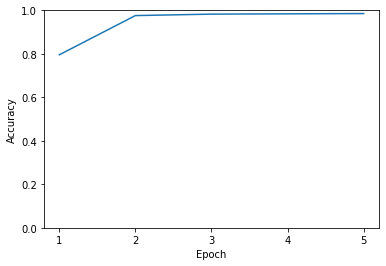

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# statistical chart
plt.plot(epochs_list, accuracies_list)
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.show()

# save model
torch.save(net.state_dict(), model_path)

## Test

In [5]:
import torch

# load net
net = Net().cuda()
model_path = model_dir / f'{net.NAME}.pth'
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy: {correct} / {total} = {correct / total}')

Net loaded
Accuracy: 9843 / 10000 = 0.9843


## Test Custom Data

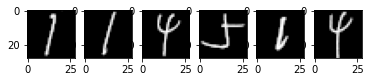

Net loaded
Predict: [1, 1, 4, 5, 1, 4]


In [6]:
from pathlib import Path
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch

custom_dir = Path('custom_data')
data_dir = custom_dir / '1'

# read images
imgs = [(int(i.stem), i) for i in data_dir.glob('*.png')]
imgs.sort()
imgs = [Image.open(i[1]) for i in imgs]

# echo images
fig, axs = plt.subplots(1, len(imgs))
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

# convert to tensor
imgs = torch.stack([transform(i) for i in imgs])

# load net
net = Net().cuda()
model_path = model_dir / f'{net.NAME}.pth'
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# exec
with torch.no_grad():
    outputs = net(imgs.cuda())
    _, predicted = torch.max(outputs.data, 1)
print(f"Predict: {predicted.tolist()}")

## Test Custom Data with Pytorch Dataset & DataLoader

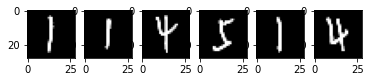

Net loaded
Predict: [1, 1, 4, 5, 1, 4]


In [7]:
from pathlib import Path
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

custom_dir = Path('custom_data')
data_dir = custom_dir / '2'

# read images
imgs = [(int(i.stem), i) for i in data_dir.glob('*.png')]
imgs.sort()
imgs = [Image.open(i[1]) for i in imgs]

# echo images
fig, axs = plt.subplots(1, len(imgs))
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()


# Dataset
class CustomTestDataset(Dataset):
    def __init__(self):
        self.data = []
        for img in imgs:
            image = transform(img)
            label = ''
            self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


# DataLoader
customTestDataset = CustomTestDataset()
customTestDataLoader = DataLoader(
    dataset=customTestDataset,
    batch_size=2,
    pin_memory=True,
    shuffle=False
)

# load net
net = Net().cuda()
model_path = model_dir / f'{net.NAME}.pth'
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# exec
res = []
with torch.no_grad():
    for data in customTestDataLoader:
        images = data[0].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        res.extend(predicted.tolist())
print(f"Predict: {res}")